In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from gstools import SRF, Gaussian,CovModel,Exponential
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
counties = gpd.read_file("data/counties_latlong.geojson")

In [3]:
class GWR_gau(CovModel):
    def correlation(self,r):
        return np.exp(-0.5*(r/self.len_scale)**2)

In [4]:
def grf(len_scale,seed):
    model = GWR_gau(dim=2, var=3,len_scale=len_scale)
    srf = SRF(model,mean=2,seed=seed)
    b1 = srf((counties.geometry.centroid.x, counties.geometry.centroid.y))
    b1 = b1 - b1.mean()
    return b1

In [5]:
b1 = grf(4,seed=222)
#counties.plot(b1,legend=True,vmin=-2,vmax=2,figsize=(10,5))

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_8297/2031343175.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  b1 = srf((counties.geometry.centroid.x, counties.geometry.centroid.y))


/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_8297/2031343175.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  b1 = srf((counties.geometry.centroid.x, counties.geometry.centroid.y))


<Axes: >

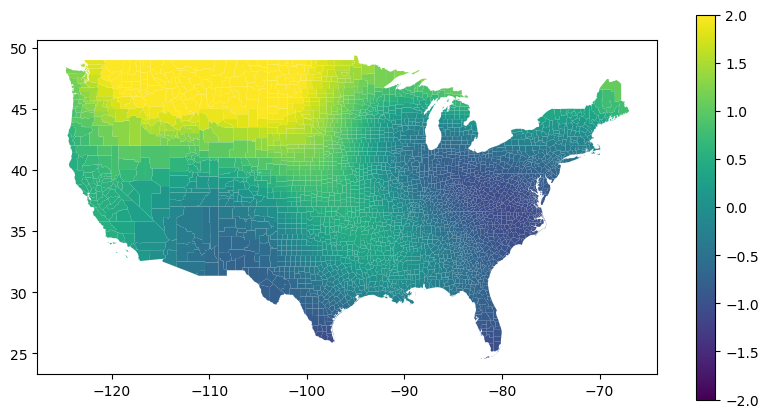

In [6]:
b2 = grf(10,seed=888)
counties.plot(b2,legend=True,vmin=-2,vmax=2,figsize=(10,5))

In [7]:

def plot_s(bs,vmin=None,vmax=None, title = ""):
    k = len(bs)
    #fig, axs = plt.subplots(1, k,figsize=(8*k,4),dpi=600)
    
    
    fig = plt.figure(figsize=(8*k,4),dpi=600)
    gs = gridspec.GridSpec(1, 10)
    
    # Define the subplots
    ax1 = fig.add_subplot(gs[0, :3])  # First row, span all columns
    ax2 = fig.add_subplot(gs[0, 3:6])  # Second row, first and second columns
    ax3 = fig.add_subplot(gs[0, -4:-2])  # Second and third rows, third column
    ax4 = fig.add_subplot(gs[0, -2:])  # Third row, first column

    axs = [ax1,ax2,ax3,ax4]
    
    for i in range(2):
        counties.plot(ax = axs[i], column=bs[i],legend=True,vmin=vmin,vmax=vmax,figsize=(12,12))
        
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))
        #axs[i].set_axis_off()
        
        if i ==0:
            axs[i].set_title(r"$\beta_1$",fontsize=20, y=1.02)
        if i ==1:
            axs[i].set_title(r"$\beta_2$",fontsize=20, y=1.02)
    
    for i in range(k):
        if i == 2:
            axs[i].scatter(X1,bs[i],s=5)            
            axs[i].set_title(r"$X_1^2$",fontsize=20, y=1.02)
            
            axs[i].set_xlim(-2.5,2.5)
            axs[i].set_ylim(-1,5)
        if i == 3:
            axs[i].scatter(X2,bs[i],s=5)
            #axs[i].set_xlabel(r"$X_2$",fontsize=16)
            axs[i].set_title(r"$2X_2$",fontsize=20, y=1.02)
            
            axs[i].set_xlim(-2.5,2.5)
            axs[i].set_ylim(-5,5)
            
    fig.suptitle(title, fontsize=25,y=1.1)
    

In [8]:
n = b1.shape[0]
b0 = np.ones(n)*3

In [9]:
np.random.seed(111)
X1 = np.random.uniform(-2,2,n)
X2 = np.random.uniform(-2,2,n)

X = np.vstack([X1,X2]).T

In [10]:
X1.shape

(3109,)

In [11]:
np.random.seed(111)

f0 = b0
f1 = b1*X1 + X1**2
f2 = b2*X2 + X2*2

err = np.random.randn(n)*0.5

y = (f0 + f1 + f2 + err).reshape(-1)

In [12]:
X_coords = pd.DataFrame(X, columns=['X1','X2'])

In [13]:
1 - np.sum((err)**2)/np.sum((y-y.mean())**2)

0.9786082288789468

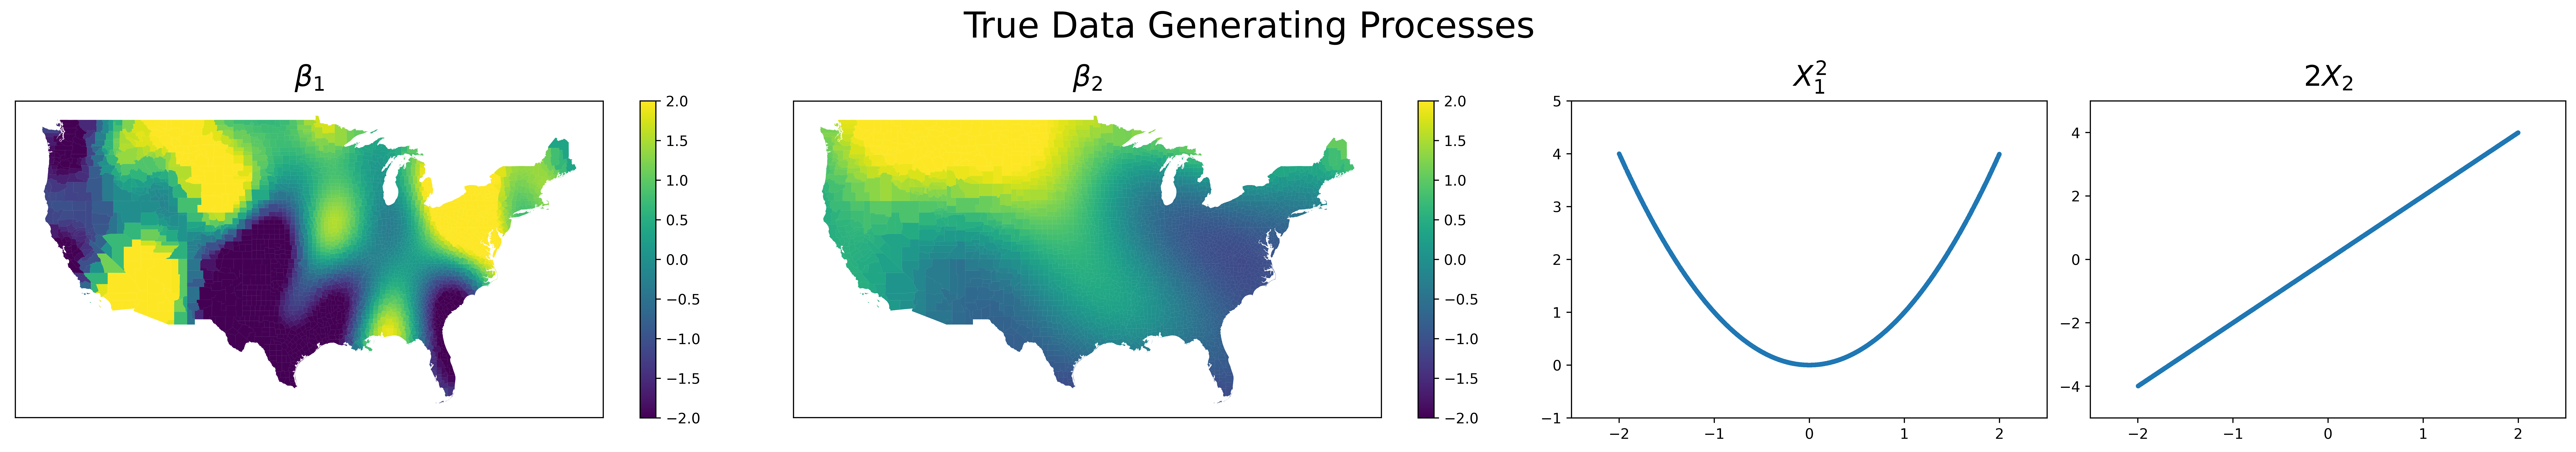

In [14]:
plot_s(np.vstack([b1, b2, X1**2,X2*2]),vmin=-2,vmax=2,title="True Data Generating Processes")

#plt.savefig("us_true_processes.png",bbox_inches="tight")

In [15]:
coords = np.array(list(zip(counties.geometry.centroid.x, counties.geometry.centroid.y)))

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_8297/3309622139.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.array(list(zip(counties.geometry.centroid.x, counties.geometry.centroid.y)))


In [16]:
X_coords.loc[:,['u','v']] = np.array(coords)
#(np.array(coords) - np.array(coords).mean(axis=0))/np.array(coords).std(axis=0)

In [17]:
data = X_coords.copy()

In [18]:
data['y'] = y

In [19]:
data.to_csv("data/us_coords.csv")

In [20]:
import libpysal.weights
import numpy.linalg as LA

w = libpysal.weights.Queen.from_dataframe(counties)

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_8297/4195977771.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(counties)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 409, 2078, 3098.
  W.__init__(self, neighbors, ids=ids, **kw)


In [21]:
def extract_sf(w):
    C, ids = libpysal.weights.full(w)
    n = C.shape[0]
    M = np.identity(n) - (1/n)
    MCM = np.dot(np.dot(M,C),M)
    vals, vecs = LA.eigh(MCM)
    vals, vecs = np.array(vals), np.array(vecs.T)
    #Sort vals and vecs because they aren't in descending order in python
    pairs = zip(vals, vecs)
    svals = sorted(vals, reverse=True)
    stups = [None] * len(svals)
    for e_val, vector in pairs:
        stups[svals.index(e_val)] = (e_val, vector)
        svals[svals.index(e_val)] = None
    vecs = np.array([x[1] for x in stups])
    vals = np.array([x[0] for x in stups])
    return vals, vecs

In [22]:
vals, vecs = extract_sf(w)

In [23]:
data = vecs[range(0,200,1)]
moran = data.T

In [24]:
data_moran = pd.DataFrame(X, columns=['X1','X2'])

In [25]:
moran_names = ["moran_" + str(i) for i in range(moran.shape[1])]

data_moran.loc[:,moran_names] = moran

In [26]:
data_moran.loc[:,['u','v']] = coords

In [27]:
data_moran['y'] = y

/var/folders/mp/9px298sd6vs8xccb_3sql0dr0000gp/T/ipykernel_8297/4098869430.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_moran['y'] = y


In [28]:
data_moran.to_csv("data/us_moran_queen.csv")

In [29]:
moran_exp = pd.read_csv("data/us_moran_exp_exact.csv")

In [30]:
data_moran.iloc[:,2:-3] = moran_exp.values

In [31]:
data_moran.to_csv("data/us_moran_exp.csv")